In [193]:
import numpy as np
import pandas as pd
import scipy.stats as stat
from scipy.stats import norm
import scipy.interpolate
import statistics
from statistics import NormalDist
import datetime as dt
import matplotlib.pyplot as plt

## Data Pre-processing

In [194]:
sofr = pd.read_excel("data/hist_data.xlsm", "SofrCurve", index_col=0)
aapl = pd.read_excel("data/hist_data.xlsm", "AAPL", index_col=0)
msft = pd.read_excel("data/hist_data.xlsm", "MSFT", index_col=0)
ford = pd.read_excel("data/hist_data.xlsm", "F", index_col=0)
bac = pd.read_excel("data/hist_data.xlsm", "BAC", index_col=0)

dates_aapl = set(aapl.index)
dates_msft = set(msft.index)
dates_ford = set(ford.index)
dates_bac = set(bac.index)
common_dates = dates_aapl & dates_msft & dates_ford & dates_bac
not_common_dates = (dates_aapl | dates_msft | dates_ford | dates_bac) - common_dates

print("Common dates: ", len(common_dates))
print("Not common dates: ", len(not_common_dates))

Common dates:  251
Not common dates:  0


In [195]:
# Equities
equities = pd.concat([aapl, msft, ford, bac], axis=1)
equities.columns = ["AAPL", "MSFT", "F", "BAC"]
equities_change = equities.pct_change().dropna()
equities_mean = equities_change.mean()
n_aapl, n_msft, n_ford, n_bac = 1e6, 1e6, 1e6, 1e6 

# SOFR Swap
payment_tenors = ["1Y", "2Y", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", "9Y", "10Y"]
sofr_rates = sofr.drop(columns=["T"]).T
sofr_rates.index = pd.to_datetime(sofr_rates.index)
sofr_rates_change = sofr_rates.diff(axis=0).dropna()
sofr_mean = sofr_rates_change.mean(axis=0)
n_swap = 1e8

latest_sofr_rates = sofr_rates.iloc[-1]

# Combine
risk_factors_change = pd.concat([sofr_rates_change, equities_change], axis=1).dropna(axis=0)
risk_factors_cov = risk_factors_change.cov()
risk_factors_corr = risk_factors_change.corr()
risk_factors_mean = risk_factors_change.mean(axis=0)
risk_factors_std = risk_factors_change.std(axis=0)

## Functions

In [196]:
def plot_distribution(change, var, title, bins=50):
    fig, ax = plt.subplots(figsize=(15, 7))
    
    ax.set_title(title+" Approach", fontsize=14)
    ax.hist(change, bins=bins, density=True, alpha=0.5, color='blue', edgecolor='black')
    ax.axvline(-var, color='red', linestyle='--', label=f'Var Threshold (-${var:,.0f})')
    ax.text(-var, ax.get_ylim()[1] * 0.9, f' -${var:,.0f}', color='red', fontsize=12, 
            verticalalignment='top', horizontalalignment='left', fontweight='bold')
    mu, std = norm.fit(change)
    x = np.linspace(change.min(), change.max(), 10000)
    ax.plot(x, norm.pdf(x, mu, std), 'k-', linewidth=2, label=f'Normal Fit: μ={mu:.2f}, σ={std:.2f}')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    plt.show()

def full_revaluation_pnl_equities(returns_1, returns_2, returns_3, returns_4):
    return n_aapl * returns_1 + \
           n_msft * returns_2 + \
           n_ford * returns_3 + \
           n_bac * returns_4

# def swap_pricing(sofr_rates):
#     # payment_tenors = ["1Y", "2Y", "3Y", "4Y", "5Y", "7Y", "8Y", "9Y", "10Y"]
#     notional = 1e8
#     fixed_rate = 0.042
#     discount_factors = []
#     forward_rates = []
#     year_count = 1
#     for t in payment_tenors:
#         discount_factors.append(np.exp(-sofr_rates[t] * year_count))
#         if year_count == 1:
#             forward_rates.append(sofr_rates[t])
#         else:
#             forward_rates.append(discount_factors[-2] / discount_factors[-1] - 1)
#         year_count += 1
        
#     floating_leg = sum(df * f for df, f in zip(discount_factors, forward_rates))
#     fixed_leg = sum(df * fixed_rate for df in discount_factors)

#     return (floating_leg - fixed_leg) * notional

def swap_pricing(sofr_rates):
    notional = 1e8
    fixed_rate = 0.042
    discount_factors = []
    year_count = 1
    for t in payment_tenors:
        discount_factors.append(np.exp(-sofr_rates[t] * year_count))
        year_count += 1

    floating_leg = 1 - discount_factors[-1]
    fixed_leg = sum(df * fixed_rate for df in discount_factors)

    return (floating_leg - fixed_leg) * notional

def sensitivity_pnl_equities(returns_1, returns_2, returns_3, returns_4):
    return n_aapl * returns_1 + \
            n_msft * returns_2 + \
            n_ford * returns_3 + \
            n_bac * returns_4

def partial_pv01(latest_sofr_rates):
    pv01 = []
    for t in sofr_rates.columns:
        up = latest_sofr_rates.copy()
        up[t] += 1e-4
        pv01.append(swap_pricing(up) - base_swap_price)
    return pv01

def sensitivity_pnl_swap(pv01, sofr_simulated_curve):
    return sum(p * 100 * (sofr_simulated_curve - latest_sofr_rates)[t] for p, t in zip(pv01, payment_tenors))

base_swap_price = swap_pricing(latest_sofr_rates)
part_pv01 = partial_pv01(latest_sofr_rates)

## Parametric VaR

In [197]:
a = [x * 1e4 for x in part_pv01]
a += [1e6]*4

mean_portfolio = sum(risk_factors_mean * a)

cov_portfolio = np.dot(a, np.dot(risk_factors_cov, a))

z_a = norm.ppf(0.05)
parametric_VaR = abs(mean_portfolio + z_a * np.sqrt(cov_portfolio))
parametric_VaR

936889.2562429619

In [198]:
#no plot for parametric

## Monte Carlo VaR

Simulations

In [199]:
num_simulations = 100000
risk_factors_dist = np.random.multivariate_normal(risk_factors_mean, risk_factors_cov, num_simulations)

print(len(risk_factors_dist))
print(len(risk_factors_dist[0]))

sofr_dist = [s[:30] for s in risk_factors_dist]
equities_dist = [s[30:] for s in risk_factors_dist]

print(len(sofr_dist))
print(len(sofr_dist[0]))

print(len(equities_dist))
print(len(equities_dist[0]))

current_portfolio = base_swap_price + 4*1e6

100000
34
100000
30
100000
4


In [200]:
current_portfolio

6442901.999846325

Full Revaluation

In [201]:
full_revaluation = []
for i in range(num_simulations):
    equities_reval = sum((equities_dist[i] + 1) * 1e6)
    sofr_reval = swap_pricing(sofr_dist[i] + latest_sofr_rates)
    full_revaluation.append(equities_reval + sofr_reval - current_portfolio)

full_revaluation_MC_VaR = abs(np.percentile(full_revaluation, 5))
full_revaluation_MC_VaR

945028.0956750234

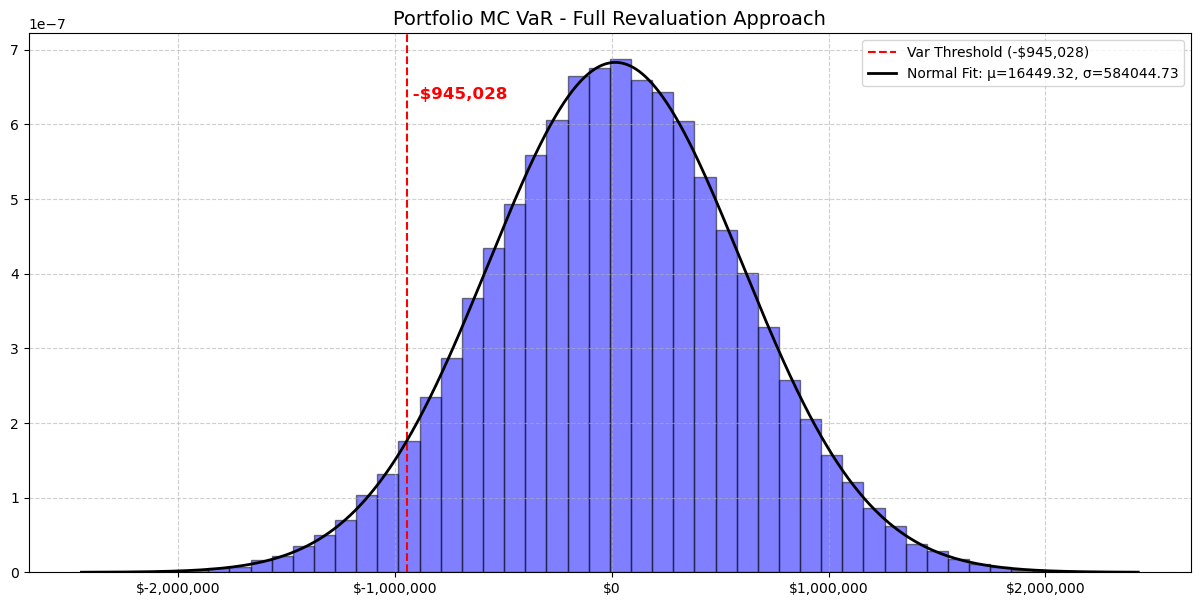

In [202]:
plot_distribution(change=np.array(full_revaluation), var=full_revaluation_MC_VaR, title="Portfolio MC VaR - Full Revaluation")

Sensitivity

In [203]:
changes = risk_factors_dist.dot(a)
sensitivity_MC_VaR = abs(np.percentile(changes, 5))
sensitivity_MC_VaR

939610.2505280612

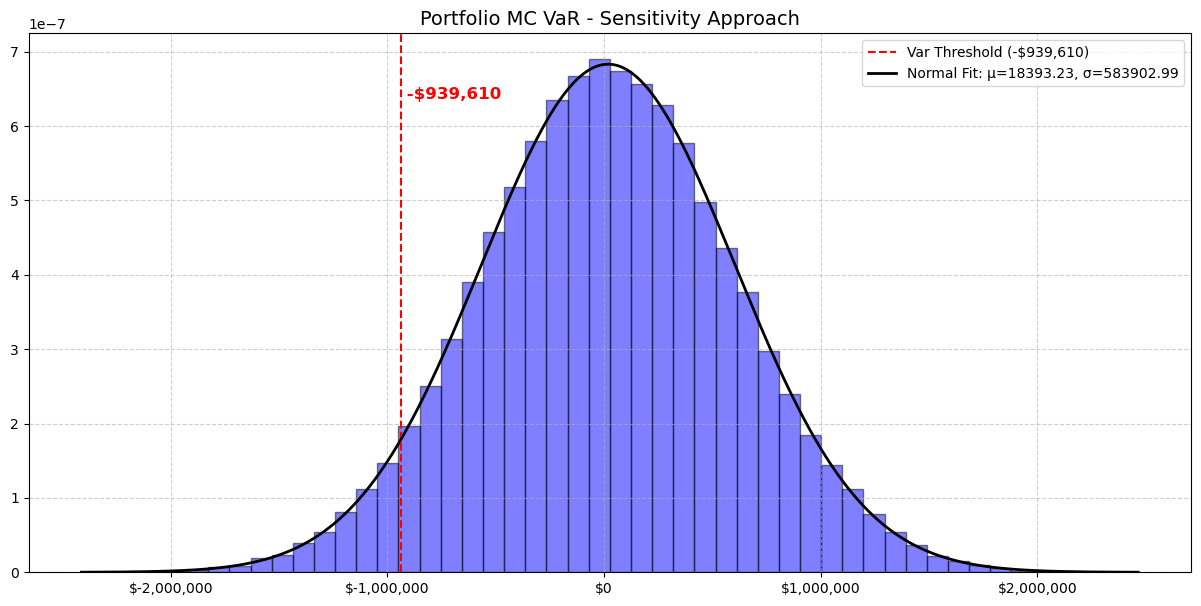

In [204]:
plot_distribution(change=changes, var=sensitivity_MC_VaR, title="Portfolio MC VaR - Sensitivity")

## Historical VaR

Full Revaluation

In [205]:
equities_portfolio = np.sum(risk_factors_change[equities.columns] + 1, axis=1) * 1e6
swap_portfolio = risk_factors_change[sofr_rates.columns].apply(lambda x: swap_pricing(x + latest_sofr_rates), axis=1)
full_portfolio_reval = equities_portfolio + swap_portfolio - current_portfolio
full_revaluation_historical_VaR = abs(np.percentile(full_portfolio_reval, 5))
full_revaluation_historical_VaR

986112.3705991704

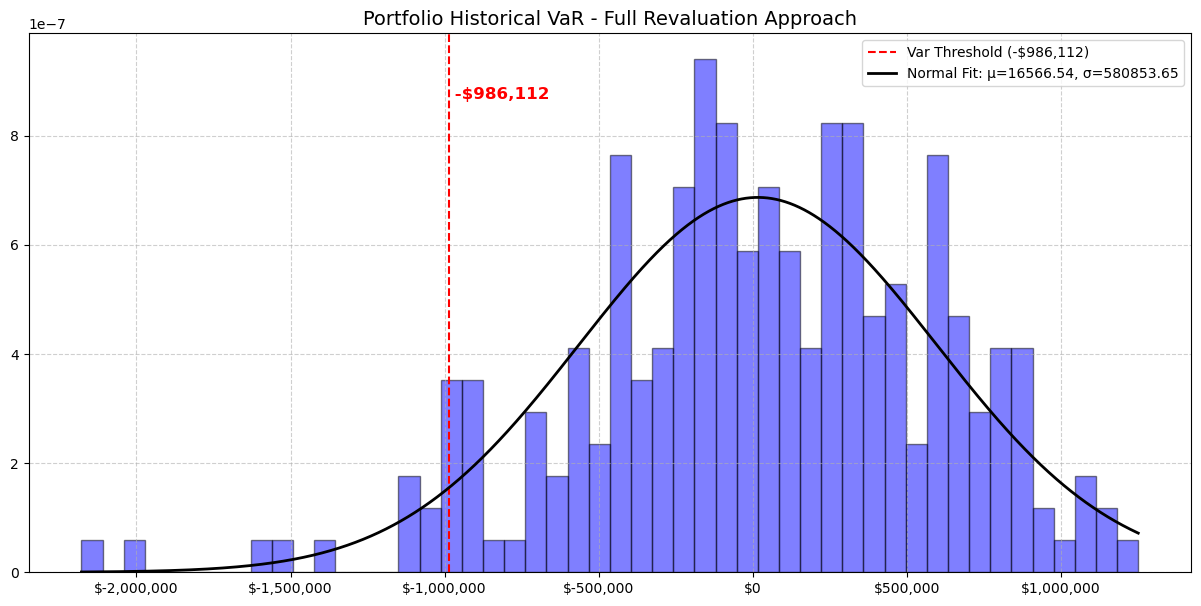

In [206]:
plot_distribution(change=full_portfolio_reval, var=full_revaluation_historical_VaR, title="Portfolio Historical VaR - Full Revaluation")

Sensitivity 

In [207]:
changes = np.array(risk_factors_change).dot(a)
sensitivity_historical_VaR = abs(np.percentile(changes, 5))
sensitivity_historical_VaR

980180.0116968255

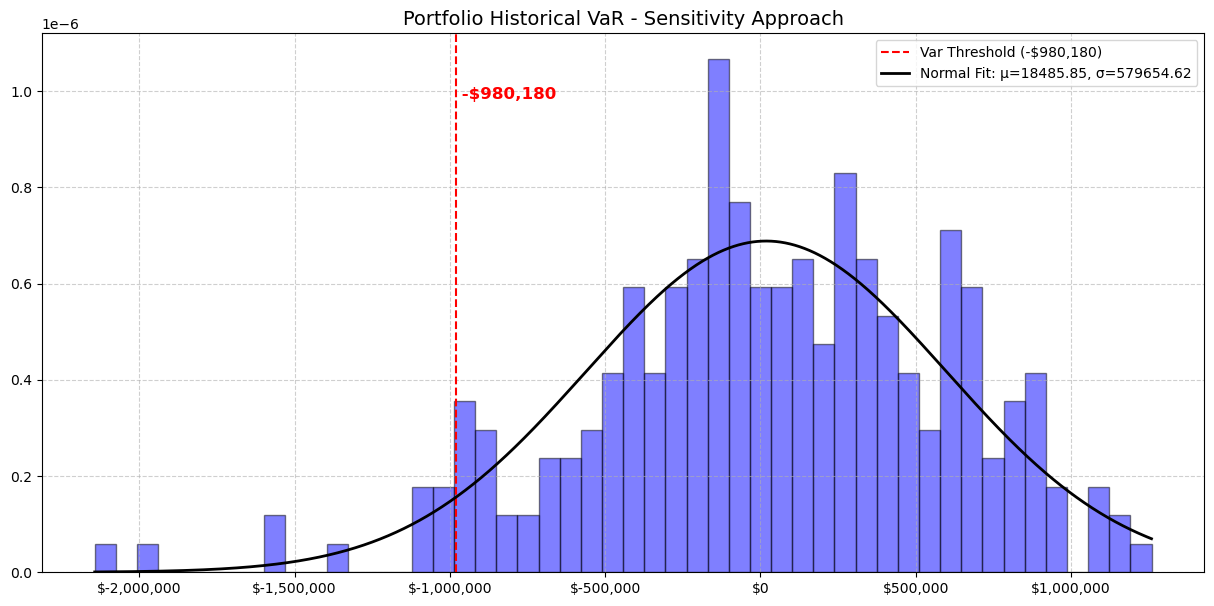

In [208]:
plot_distribution(change=changes, var=sensitivity_historical_VaR, title="Portfolio Historical VaR - Sensitivity")

## Conclusion

In [209]:
print("============================================================================================================================")
print(f"Parametric VaR [1d, 95%]: {parametric_VaR:,.0f}")
print("============================================================================================================================")
print(f"Full Revaluation Monte Carlo VaR [1d, 95%]: {full_revaluation_MC_VaR:,.0f}")
print(f"Sensitivity Monte Carlo VaR [1d, 95%]: {sensitivity_MC_VaR:,.0f}")
print("============================================================================================================================")
print(f"Full Revaluation Historical VaR [1d, 95%]: {full_revaluation_historical_VaR:,.0f}")
print(f"Sensitivity Historical VaR [1d, 95%]: {sensitivity_historical_VaR:,.0f}")

Parametric VaR [1d, 95%]: 936,889
Full Revaluation Monte Carlo VaR [1d, 95%]: 945,028
Sensitivity Monte Carlo VaR [1d, 95%]: 939,610
Full Revaluation Historical VaR [1d, 95%]: 986,112
Sensitivity Historical VaR [1d, 95%]: 980,180
